We run the main analysis script which imports the necessary libraries and provides all our functions

In [185]:
%matplotlib inline
%run src/analyse.py 

### Reading the reference 

We read the reference genome and parse it to obtain the masked regions. These regions will be relevant when we are sampling random mutations for our null model. 

We are not interested in mitochondria or chloroplast in this work so we remove them from the samples.

In [ ]:
TAIR10 = 'reference/TAIR10-masked.fa'

chromosomes  = dict()  # chromosome sequences
chrSize      = dict()  # chromosome sizes, for convenience
maskedRanges = dict()  # masked ranges in each chromosome

for chromosome in SeqIO.parse(TAIR10, 'fasta', generic_dna) :
    name, seq  = chromosome.name, chromosome.seq
    
    # ignore chloroplast and mitochondria
    if name == 'chloroplast' or name == 'mitochondria' : continue
    
    chromosomes[name]  = seq
    chrSize[name]      = len(seq) 
    maskedRanges[name] = get_masked_ranges(seq)
    
    # get total size of masked regions
    maskedSize = sum(map(lambda x : x[1]-x[0], maskedRanges[name]))
    
    print '{} is of length {}, covered {:.1f}% by masked regions'.format\
    (name, chrSize[name], maskedSize*100.0/chrSize[name])

In [119]:
# chromosome namelist for convenience
chrNames = chromosomes.keys()
chrNames.sort()

### Reading the vcf file

We parse the vcf file that was generated in the final step of the variant calling workflow to obtain all the heterozygous variants.
We call the function 

`get_hetero_variants(vcfFile, snpMinGQ=50, indelMinGQ=30, minAD=5)`

which extracts heterozygous variants that satisfy minimum genotype quality (GQ) and alelle depth (AD) requirements. 
The default values reflect the reported filters in the original publication. 

`get_hetero_variants()` returns **sample counts** for each genotype in each variant position, in each chromosome. It does not return per-sample information.


In [97]:
vcfFile = 'calls/genotype.vcf'

hetSNPs, hetIndels = get_hetero_variants(vcfFile)

In [132]:
for ch in chrNames :
    print '{}: {:6d}/{} hetero SNPs/indels, total: {}'.format \
    (ch, len(hetSNPs[ch]), len(hetIndels[ch]), len(hetSNPs[ch])+len(hetIndels[ch]))

Chr1: 141016/35974 hetero SNPs/indels, total: 176990
Chr2:  79041/19656 hetero SNPs/indels, total: 98697
Chr3: 102039/24587 hetero SNPs/indels, total: 126626
Chr4:  89621/22595 hetero SNPs/indels, total: 112216
Chr5: 133333/33662 hetero SNPs/indels, total: 166995


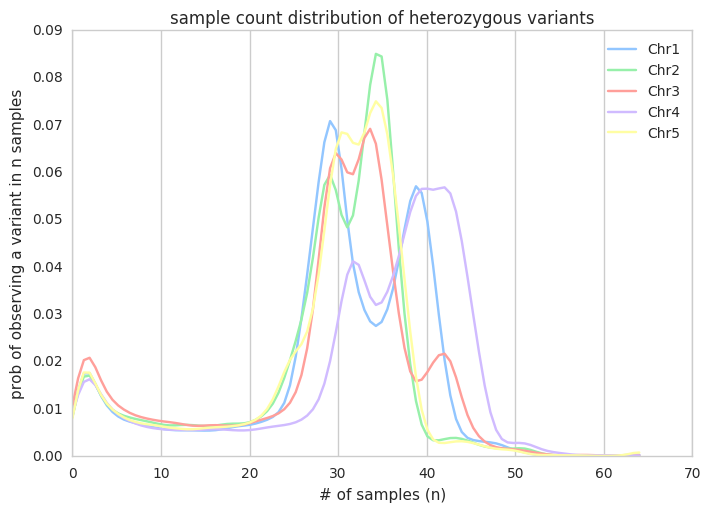

In [229]:
for ch in chrNames:
    counts = array([ counts['0/1'] for counts in hetSNPs[ch].values()])
    #ax=sns.distplot(counts, kde_kws={'cut':0} )
    ax=sns.kdeplot(counts, cut=0, label=ch)

sns.plt.legend()
ax.grid(axis='y')
ax.set_title('sample count distribution of heterozygous variants')
ax.set_ylabel('prob of observing a variant in n samples')
ax.set_xlabel('# of samples (n)')

Wherever the parent (f1) is heterozygous, we expect half of the progeny (f2) samples (32) to be heterozygous. 
Although this expectation holds, *the bimodal distribution around 32 is a little weird*. 
Maybe there is a biological mechanism that I don't know about that results in this. 

We also observe another peak around 1 which signifies denovo mutations. 
If a hetero variant is observed in a single sequence, we can safely claim a denovo mutation, but what if it is observed in 2 or 3 samples? 
That part is clearly out of the tail of the peak around 32. 
What is going on here? I don't know.

### Denovo vs. inherited variation

If we observe a heterozygous variant in more than *minInherit* samples  we claim this was inherited, therefore **f1 was heterozygous in these positions** 

If we observe a heterozygous variant in a maximum of *maxDenovo* samples, we claim **a sample in f2 has a denovo mutation in this position** 

`process_hetero_variants (variants, minInherit=10, maxDenovo=1)` 

thus splits heretozygous variants into **inherited** and **denovo** partitions. 



In [164]:
hetero_variants = dict()

for ch in chrNames :
    inheritSNPs, denovoSNPs = process_hetero_variants(hetSNPs[ch])
    inheritIndels, denovoIndels = process_hetero_variants(hetIndels[ch])
    
    thisChromosome = dict()
    
    thisChromosome['inheritSNPs'] = inheritSNPs
    thisChromosome['inheritIndels'] = inheritIndels
    thisChromosome['denovoSNPs'] = denovoSNPs
    thisChromosome['denovoIndels'] = denovoIndels
    # combined indels and snps 
    thisChromosome['denovoAll'] = sort(hstack([denovoSNPs, denovoIndels]))
    thisChromosome['inheritAll']= sort(hstack([inheritSNPs, inheritIndels]))
    
    
    hetero_variants[ch]=thisChromosome
    
    print '{}: inherited: {:6d}/{:5d} SNPs/indels, denovo: {}/{} SNPs/indels '.format \
    (ch, len(inheritSNPs), len(inheritIndels), len(denovoSNPs), len(denovoIndels) )
    

Chr1: inherited: 126255/30515 SNPs/indels, denovo: 4174/2054 SNPs/indels 
Chr2: inherited:  70455/16571 SNPs/indels, denovo: 2329/1281 SNPs/indels 
Chr3: inherited:  88765/20375 SNPs/indels, denovo: 3763/1643 SNPs/indels 
Chr4: inherited:  80184/19333 SNPs/indels, denovo: 2728/1248 SNPs/indels 
Chr5: inherited: 119098/28825 SNPs/indels, denovo: 3877/1867 SNPs/indels 


### Measure

The essence of this hypothesis is in the distance between the denovo mutations and the heterozygous regions in the parent genome. 

`get_hetero_distances(denovo, hetero)` takes two lists of positions and will calculate the distance of each denovo mutation to the closest heterozygous mutation. 

Because it is not trivial how to deal with snps vs. indels, we might as well do this thrice, for snps, indels and combined. 


Let's do this for SNPs first : 

In [172]:
hetero_distances = dict()

for ch in chrNames :
    
    thisChr = hetero_variants[ch]
    
    dist = dict()
    
    # for snps
    dist['snp'] = get_hetero_distances(thisChr['denovoSNPs'], thisChr['inheritSNPs'])
    
    # for indels

    dist['indel'] = get_hetero_distances( thisChr['denovoIndels'], thisChr['inheritIndels'] )
    
    # combined

    dist['combined'] = get_hetero_distances(thisChr['denovoAll'], thisChr['inheritAll'])
    
    hetero_distances[ch]=dist
    
    print ch, mean(dist['snp']), mean(dist['indel']), mean(dist['combined'])
    

Chr1 260.135122185 1308.87925998 225.931599229
Chr2 297.264920567 1097.53786105 277.906371191
Chr3 258.634334308 1286.89531345 235.231409545
Chr4 506.761363636 910.356570513 402.881790744
Chr5 211.622646376 980.467595072 203.993036212


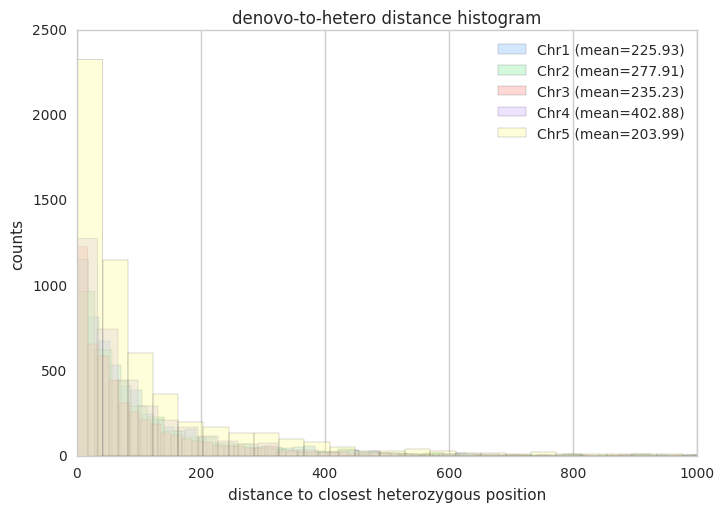

In [252]:
for ch in chrNames:
    dist = hetero_distances[ch]['combined']
    ax=sns.distplot(dist, kde=False, bins=1500, label='{} (mean={:.2f})'.format(ch,mean(dist)))
    #ax=sns.kdeplot(hetero_distances[ch]['combined'], cut=0, label=ch)

sns.plt.legend()
ax.grid(axis='y')
ax.set_title('denovo-to-hetero distance histogram')
ax.set_ylabel('counts')
ax.set_xlabel('distance to closest heterozygous position')
ax.set_xbound(upper=1000)
#ax.set_xscale('log')


We can easily see that these are heavy tailed distributions. 
I had to cut the tails out of plots, and means are not necessarily informative in such distributions. 

### Null model


We now have the observed mutation-to-hetero distances per chromosome. It is time to compare it to a **null model**. 

We build a null model by sampling the same number of positions randomly from the chromosome and measuring the average distance to the closest heterozygous position. 

We repeat the experiment `nullsamples` times and report mean and std for the null model.

We report the observed value versus the mean and std of the null model to attempt to reject the null.

In [253]:
nullSamples = 1000

null_model = dict()

for ch in chrNames :
    null_dist = list()
    ndenovo = len(hetero_variants[ch]['denovoAll'])
    
    for i in range(nullSamples) :
        null_denovo = sample_mutations(ndenovo, maskedRanges[ch], chrSize[ch] )
        null_dist.append (mean(get_hetero_distances(null_denovo, hetero_variants[ch]['inheritAll'])))
    
    null_model[ch] = null_dist
    
    print '{}: observed: {:.2f} null: {:.2f}/{:.2f} mean/std'.format\
    (ch, mean(hetero_distances[ch]['combined']), mean(null_dist), std(null_dist))

Chr1: observed: 225.93 null: 2843.43/142.03 mean/std
Chr2: observed: 277.91 null: 1285.89/58.99 mean/std
Chr3: observed: 235.23 null: 1228.48/42.72 mean/std
Chr4: observed: 402.88 null: 1769.08/87.89 mean/std
Chr5: observed: 203.99 null: 1947.93/100.38 mean/std


Surprisingly enough, it looks like we have good reason to reject the null hypothesis.

### Complete null model

If we sample all non-masked positions in each chromosome rather than some number of mutations, we can see the convergent state of our null model, this will give us a maximally informed distribution. 

In [184]:
complete_null = dict()

for ch in chrNames :
    # get all the non-masked positions 
    allChromosome = list()
    here = 0 
    for r in maskedRanges[ch] : 
        allChromosome += range(here, r[0])
        here = r[1]
    allChromosome = array(sorted(allChromosome), dtype=int)

    dist = get_hetero_distances(allChromosome, hetero_variants[ch]['inheritAll'])
    
    complete_null[ch] = dist
    
    print ch, mean(dist), std(dist)

Chr1 958.011017568 3668.36055703
Chr2 593.785671552 1980.12846451
Chr3 608.348501697 1680.09555205
Chr4 510.077802624 1984.47875627
Chr5 886.246112729 5011.90265832


We can see that means are a little lower than our null 'experiment's but the std is much larger. 
These are <del>power law</del> heavy tailed distributions. 
This means the first two moments (mean and std) might not be very informative. 

It might be a good idea to approach with a information theoretical measure involving whole distributions rather than simple moments to this analysis. 

I will do this later.

Also note that there is another culling step that removes some variants from the pool. 

I will maybe do that laer too.

In [93]:
hist(dist, bins=range(0,1000,10), label='true', normed=True)
hist(null_dist, bins=range(0,1000,10), label='null', normed=True)
legend()
print max(dist), max(null_dist)

44031 144493


In [178]:
hist(all_dist, bins=range(0,1000,10), label='full', normed=True)
print mean(all_dist), std(all_dist)

1120.86098331 4026.48978733
